In [21]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load your labeled dataset
df = pd.read_csv("labeled_dataset_4_categories.csv")

# Keep only relevant text
df = df[df["Semantic_Label_4"].isin(["support_ban", "oppose_ban", "neutral", "unrelated"])].copy()
df.reset_index(drop=True, inplace=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeetshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jeetshah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jeetshah/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [28]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    stop_words = set(stopwords.words("english"))
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

# Apply cleaning
df["tokens"] = df["Text"].apply(clean_text)
df["clean_text"] = df["tokens"].apply(lambda x: ' '.join(x))
df["text"]

,Text,Semantic_Label_4,tokens,clean_text
0,Plastic On The Mind: Assessing the Risks From ...,support_ban,"[plastic, mind, assessing, risk, micro, nanopl...",plastic mind assessing risk micro nanoplastics...
1,Scenic loch becomes magnet for Scotland's plas...,neutral,"[scenic, loch, becomes, magnet, scotland, plas...",scenic loch becomes magnet scotland plastic wa...
2,Trump rolls back standards for water-using app...,oppose_ban,"[trump, roll, back, standard, waterusing, appl...",trump roll back standard waterusing appliance ...
3,Why Aren’t We Losing Our Minds Over the Plasti...,support_ban,"[arent, losing, mind, plastic, brain, brain, f...",arent losing mind plastic brain brain full pla...
4,36 Products That’ll Help Get You Through TSA F...,support_ban,"[product, thatll, help, get, tsa, faster, cade...",product thatll help get tsa faster cadence aap...
...,...,...,...,...
3443,The new green revolution in crop genetics It i...,support_ban,"[new, green, revolution, crop, genetics, visio...",new green revolution crop genetics vision peop...
3444,You can't deny it - nuclear weapons are a stup...,oppose_ban,"[cant, deny, nuclear, weapon, stupid, risk, is...",cant deny nuclear weapon stupid risk israeli m...
3445,US study shows GM crops 'no better' A two-year...,support_ban,"[study, show, crop, better, twoyear, study, go...",study show crop better twoyear study governmen...
3446,Monsanto hints at U-turn on GM food in Britain...,support_ban,"[monsanto, hint, uturn, food, britain, monsant...",monsanto hint uturn food britain monsanto biot...


In [31]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.95, min_df=10, max_features=1000)
X_counts = vectorizer.fit_transform(df["clean_text"])


vocab = vectorizer.get_feature_names_out()

In [32]:
# Convert the document-term matrix to a readable DataFrame
import pandas as pd

# 'X_counts' is the output from CountVectorizer
df_after_vectorization = pd.DataFrame(X_counts.toarray(), columns=vectorizer.get_feature_names_out())

# Display first few rows of transformed data
df_after_vectorization.head()


,able,access,according,account,achieve,across,act,action,activist,activity,...,worst,worth,would,wrote,year,yet,york,young,youre,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
from sklearn.decomposition import LatentDirichletAllocation


n_topics = 4

lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10,
                                learning_method='online', random_state=42)
lda.fit(X_counts)

LatentDirichletAllocation(learning_method='online', n_components=4,
                          random_state=42)

In [25]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vocab, 10)



Topic 1:
water, said, year, say, one, people, use, also, time, could

Topic 2:
plastic, waste, bag, said, recycling, year, bottle, product, food, packaging

Topic 3:
energy, carbon, emission, power, gas, fuel, year, said, would, use

Topic 4:
climate, said, government, country, change, global, world, would, company, year


In [26]:
import pyLDAvis
pyLDAvis.enable_notebook()
# Prepare and show the LDA visualization (without mds='tsne')
panel = pyLDAvis.prepare(
    topic_term_dists=lda.components_ / lda.components_.sum(axis=1)[:, None],
    doc_topic_dists=lda.transform(X_counts),
    doc_lengths=[len(doc) for doc in df["clean_text"]],
    vocab=vectorizer.get_feature_names_out(),
    term_frequency=X_counts.toarray().sum(axis=0)
)

# Show inside notebook
panel


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.046644 -0.003770       1        1  37.153459
3      0.131524 -0.074238       2        1  23.900961
1     -0.122435 -0.041620       3        1  20.729955
2      0.037555  0.119628       4        1  18.215625, topic_info=           Term           Freq          Total Category  logprob  loglift
655     plastic  146985.000000  146985.000000  Default  30.0000  30.0000
291      energy   64419.000000   64419.000000  Default  29.0000  29.0000
163     climate   85311.000000   85311.000000  Default  28.0000  28.0000
960       waste   58544.000000   58544.000000  Default  27.0000  27.0000
71          bag   40528.000000   40528.000000  Default  26.0000  26.0000
..          ...            ...            ...      ...      ...      ...
779         say   12608.478259   75441.830027   Topic4  -5.0424  -0.0861
542        make   10770.187584   42503.465521   Topic4  -5.2000   0.3301
397  government   12055.208168   68055.711207   Topic4  -5.0872  -0.0279
592        need   10840.009301   44071.175948   Topic4  -5.1935   0.3003
615         one   11209.035430   70344.347610   Topic4  -5.1600  -0.1338

[265 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
7         1  0.101915          action
7         2  0.759588          action
7         3  0.132489          action
7         4  0.006019          action
15        1  0.065263  administration
...     ...       ...             ...
994       4  0.197482            year
997       1  0.936292           young
997       2  0.036365           young
997       3  0.013582           young
997       4  0.013874           young

[812 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

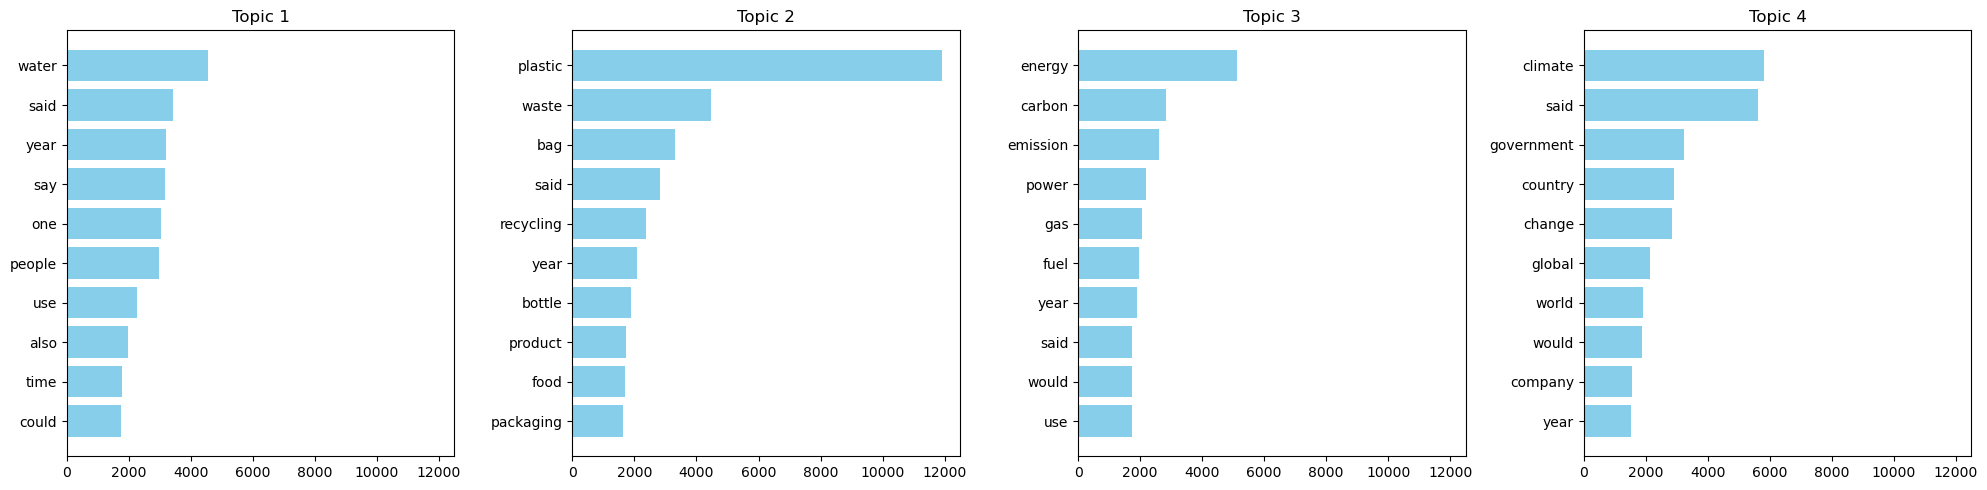

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_words(model, feature_names, n_top_words=10):
    n_topics = model.n_components
    fig, axes = plt.subplots(1, n_topics, figsize=(20, 5), sharex=True)
    
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_indices]
        weights = topic[top_indices]
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='skyblue')
        ax.set_title(f"Topic {topic_idx + 1}")
        ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Run the plot function
plot_top_words(lda, vocab)
